In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:


import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable



from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [12]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [13]:
batch_images1 = []
batch_images2 = []
for batch_idx, (data, target) in enumerate(siamese_train_loader):
    target = target if len(target) > 0 else None
    if not type(data) in (tuple, list):
        data = (data,)
    batch_images1 = data[0]
    batch_images2 = data[1]
    break


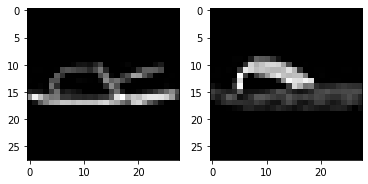

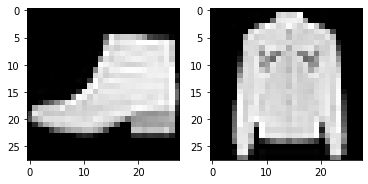

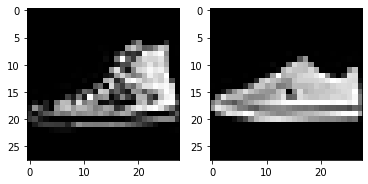

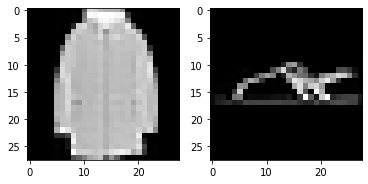

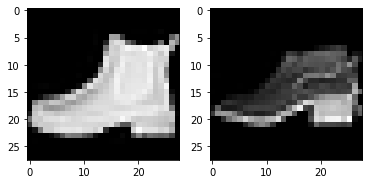

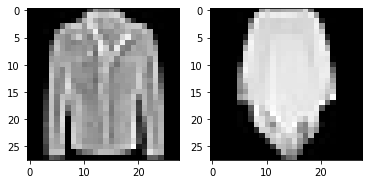

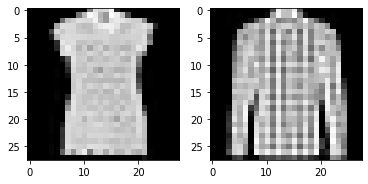

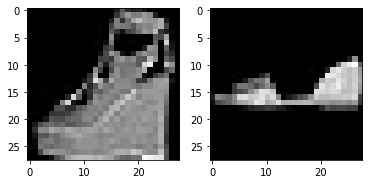

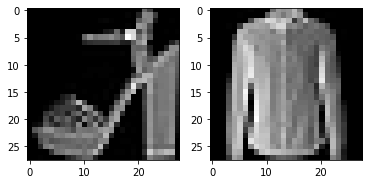

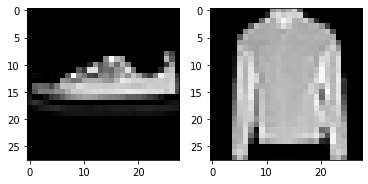

In [14]:
ind = 0
for i in range(len(batch_images1)):
    plt.subplot(121)
    plt.imshow(batch_images1[i].reshape(28,28),cmap="gray")
    plt.subplot(122)
    plt.imshow(batch_images2[i].reshape(28,28),cmap="gray")
    plt.show()


# Training

In [15]:
# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20 # change this to 20
log_interval = 100

In [16]:
epochlosses = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.221350
Train: [12800/60000 (21%)]	Loss: 0.060641
Train: [25600/60000 (43%)]	Loss: 0.049266
Train: [38400/60000 (64%)]	Loss: 0.044615
Train: [51200/60000 (85%)]	Loss: 0.043453
Epoch: 1/20. Train set: Average loss: 0.0489
Epoch: 1/20. Validation set: Average loss: 0.0410
Train: [0/60000 (0%)]	Loss: 0.038341
Train: [12800/60000 (21%)]	Loss: 0.040557
Train: [25600/60000 (43%)]	Loss: 0.036801
Train: [38400/60000 (64%)]	Loss: 0.036184
Train: [51200/60000 (85%)]	Loss: 0.036432
Epoch: 2/20. Train set: Average loss: 0.0371
Epoch: 2/20. Validation set: Average loss: 0.0349
Train: [0/60000 (0%)]	Loss: 0.028578
Train: [12800/60000 (21%)]	Loss: 0.032655
Train: [25600/60000 (43%)]	Loss: 0.032234
Train: [38400/60000 (64%)]	Loss: 0.031654
Train: [51200/60000 (85%)]	Loss: 0.031708
Epoch: 3/20. Train set: Average loss: 0.0318
Epoch: 3/20. Validation set: Average loss: 0.0328
Train: [0/60000 (0%)]	Loss: 0.020363
Train: [12800/60000 (21%)]	Loss: 0.029663
Train: [25600/60000 (

In [17]:
torch.save(model.state_dict(),"siamese_FASHION_MNIST")

In [18]:
model.load_state_dict(torch.load("siamese_FASHION_MNIST"))

<All keys matched successfully>

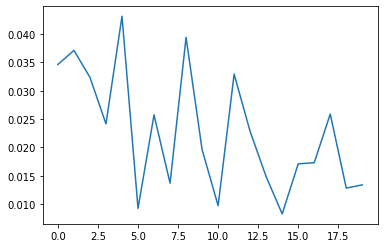

In [19]:
import matplotlib.pyplot as plt 
epochs = []
losses = []
for epoch,loss in epochlosses:
    epochs.append(epoch)
    losses.append(loss[-1])
plt.plot(epochs,losses)
plt.show()


# Results

In [20]:

with torch.no_grad():
        model.eval()
        difference_coeffs = np.zeros((len(siamese_test_loader.dataset), 2))
        k=0
        for batch_idx, (data, target) in enumerate(siamese_test_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            images0 = data[0].cuda()
            images1 = data[1].cuda()
            img0embeddings = model.get_embedding(images0).data.cpu().numpy()
            img1embeddings = model.get_embedding(images1).data.cpu().numpy()
            diff = np.array([])

            #for every image set in the batch
            for i in range(len(img0embeddings)):
                dist = np.square(img0embeddings[i][0]-img1embeddings[i][0]) + np.square(img0embeddings[i][1]-img1embeddings[i][1]) 
                dist_tar = np.array([dist,int(target[i])])
                diff = np.append(diff,dist_tar)
            
            diff = np.reshape(diff, (-1, 2))
            difference_coeffs[k:k+len(images0)] = diff
            k += len(images0)
            
            

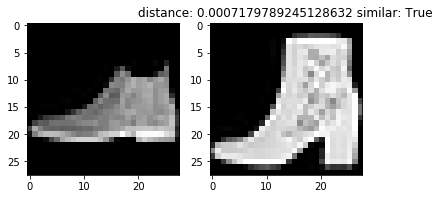

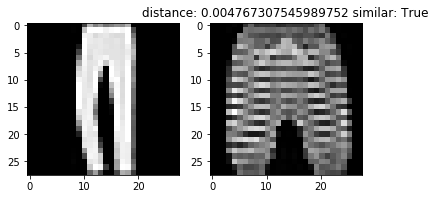

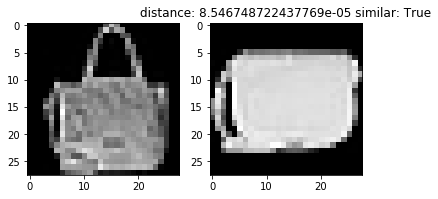

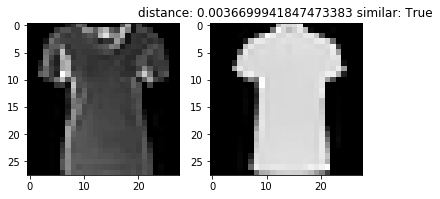

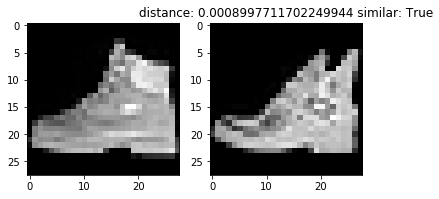

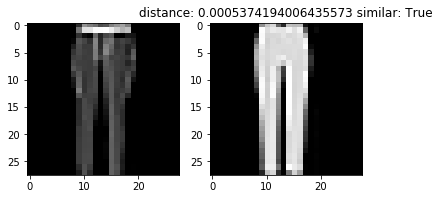

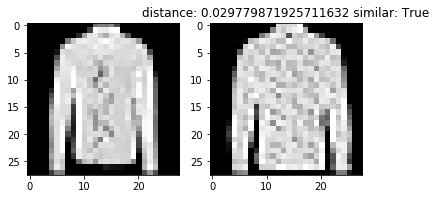

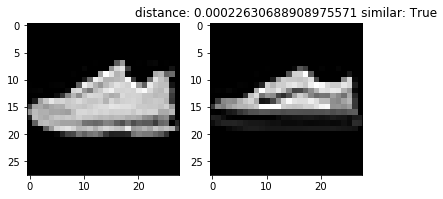

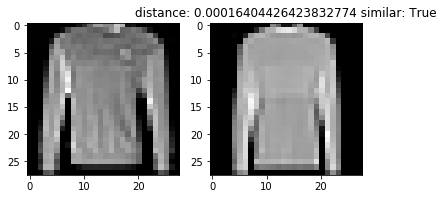

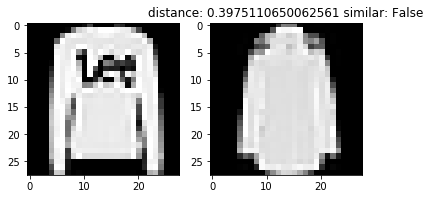

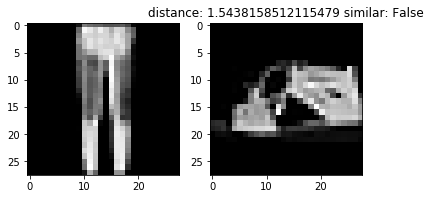

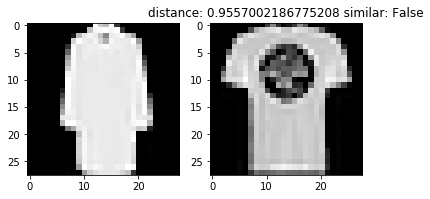

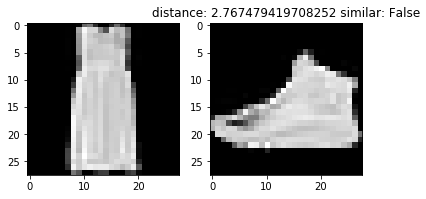

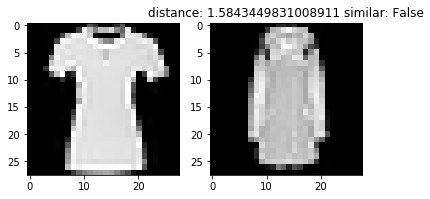

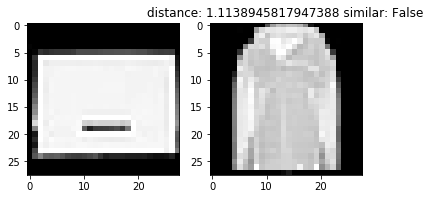

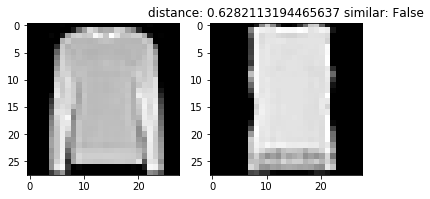

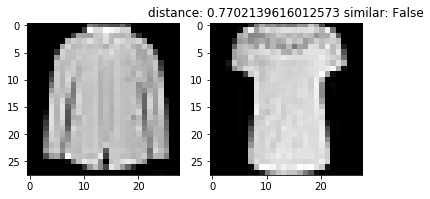

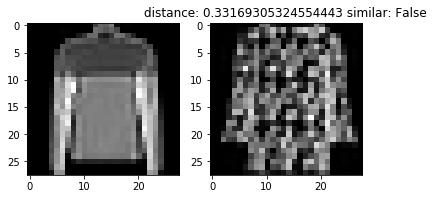

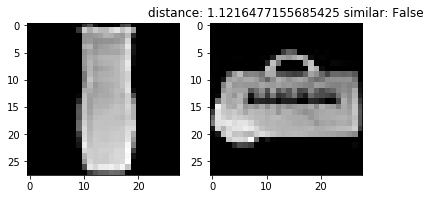

In [21]:
# print(len(difference_coeffs))
for i in range(2):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(1000,1001):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(2000,2002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(3000,3002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(4000,4002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(5000,5002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(6000,6002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(7000,7002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(8000,8002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")

for i in range(9000,9002):
    sample = siamese_test_loader.dataset[i]
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2) # two axes on figure
    plt.title("distance: " + str(difference_coeffs[i][0])+ " similar: " + str(bool(difference_coeffs[i][1])))
    ax1.imshow(sample[0][0].reshape(28,28),"gray")
    ax2.imshow(sample[0][1].reshape(28,28),"gray")




# Visualize Predictions
Based on our results, we can set a thresold for distance i.e 0.5 for which, 
similar images will have the siamese distance < 0.5 and different ones will give a greater distance

In [22]:
distances = difference_coeffs[:,0]
targets = difference_coeffs[:,1]
print(distances.shape)
print(targets.shape)

(10000,)
(10000,)


In [23]:
threshold = 0.5

In [24]:
predictions = np.array([])
for x in distances:
    if(x < threshold):
        predictions = np.append(predictions,1.0)
    else:
        predictions = np.append(predictions,0.0)

In [25]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(targets, predictions)

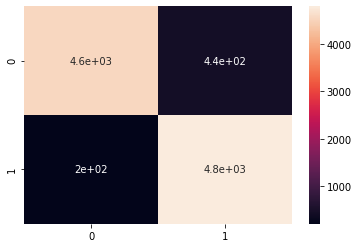

In [26]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [27]:
print(model)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)


In [29]:
cf

array([[4562,  438],
       [ 203, 4797]], dtype=int64)